In [1]:
!pip install -q findspark

In [2]:
from pyspark.sql import SparkSession
name="Churn_risk_logistic_regression"


spark = SparkSession.builder.appName(name).master("local[*]").getOrCreate()

24/11/14 10:43:15 WARN Utils: Your hostname, MacBook-Pro-de-Jaime.local resolves to a loopback address: 127.0.0.1; using 192.168.1.133 instead (on interface en0)
24/11/14 10:43:16 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/14 10:43:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [8]:
spark

In [9]:
customer= "/Users/jaimecastro/Desktop/master/BIG_DATA/customer_churn.csv.xls"
customer_df=spark.read.format("csv")\
                    .options(header=True, inferschema=True,delimiter=",")\
                    .load(customer)


In [6]:
customer_df.printSchema()

root
 |-- Names: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Total_Purchase: double (nullable = true)
 |-- Account_Manager: integer (nullable = true)
 |-- Years: double (nullable = true)
 |-- Num_Sites: double (nullable = true)
 |-- Onboard_date: timestamp (nullable = true)
 |-- Location: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Churn: integer (nullable = true)



In [7]:
customer_df.toPandas().describe()

,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Churn
count,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000
mean,41.816667,10062.824033,0.481111,5.273156,8.587778,0.166667
std,6.127560,2408.644532,0.499921,1.274449,1.764836,0.372885
min,22.000000,100.000000,0.000000,1.000000,3.000000,0.000000
25%,38.000000,8497.122500,0.000000,4.450000,7.000000,0.000000
50%,42.000000,10045.870000,0.000000,5.215000,8.000000,0.000000
75%,46.000000,11760.105000,1.000000,6.110000,10.000000,0.000000
max,65.000000,18026.010000,1.000000,9.150000,14.000000,1.000000


In [8]:
customer_df.toPandas().head()

,Names,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Onboard_date,Location,Company,Churn
0,Cameron Williams,42.0,11066.80,0,7.22,8.0,2013-08-30 07:00:40,"10265 Elizabeth Mission Barkerburgh, AK 89518",Harvey LLC,1
1,Kevin Mueller,41.0,11916.22,0,6.50,11.0,2013-08-13 00:38:46,"6157 Frank Gardens Suite 019 Carloshaven, RI 1...",Wilson PLC,1
2,Eric Lozano,38.0,12884.75,0,6.67,12.0,2016-06-29 06:20:07,"1331 Keith Court Alyssahaven, DE 90114","Miller, Johnson and Wallace",1
3,Phillip White,42.0,8010.76,0,6.71,10.0,2014-04-22 12:43:12,"13120 Daniel Mount Angelabury, WY 30645-4695",Smith Inc,1
4,Cynthia Norton,37.0,9191.58,0,5.56,9.0,2016-01-19 15:31:15,"765 Tricia Row Karenshire, MH 71730",Love-Jones,1


In [9]:
customer_df.toPandas().tail()

,Names,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Onboard_date,Location,Company,Churn
895,Paul Miller,42.0,12800.82,1,3.62,8.0,2007-12-01 13:29:34,"9316 Julian Fort Suite 328 North Leslie, ME 43961",Evans-Lucero,0
896,Natalie Hodges,52.0,9893.92,0,6.91,7.0,2008-12-28 15:23:58,"8419 William Square Apt. 695 Martinville, RI 3...",Perry and Sons,0
897,Ana Smith,45.0,12056.18,0,5.46,4.0,2014-06-20 05:10:09,Unit 8633 Box 8738 DPO AA 14126-5026,Schneider-Smith,0
898,Justin Leonard,51.0,6517.93,1,5.47,10.0,2012-05-30 00:15:43,"49800 Torres Ways Suite 886 West Bradleybury, ...",Robles-Abbott,0
899,Joseph Williams,39.0,9315.60,1,5.02,10.0,2010-09-25 12:16:08,"27252 Olivia Burgs Rivasmouth, MN 80121-6348",Davis Group,0


Check null values

In [10]:
from pyspark.sql.functions import when, count, col

customer_df.select([count(when(col(c).isNull(), c)).alias(c) for c in customer_df.columns]).show() 


+-----+---+--------------+---------------+-----+---------+------------+--------+-------+-----+
|Names|Age|Total_Purchase|Account_Manager|Years|Num_Sites|Onboard_date|Location|Company|Churn|
+-----+---+--------------+---------------+-----+---------+------------+--------+-------+-----+
|    0|  0|             0|              0|    0|        0|           0|       0|      0|    0|
+-----+---+--------------+---------------+-----+---------+------------+--------+-------+-----+



# EDA

In [10]:
customer_df.createOrReplaceTempView('customer_df')

In [16]:
#Check how many companies are. If there are many different companies, then I will drop it as it´s not likely to influence in the prediction.
spark.sql("""
    SELECT Company, COUNT(*) as count 
    FROM customer_df
    GROUP BY Company
""").show()


+--------------------+-----+
|             Company|count|
+--------------------+-----+
|Miller, Johnson a...|    1|
|Hunter, Reyes and...|    1|
|          Obrien PLC|    1|
|            Soto PLC|    2|
|            Todd LLC|    1|
|Smith, Marshall a...|    1|
|           Smith PLC|    1|
|          Hall Group|    1|
|Freeman, Lam and ...|    1|
|       Smith-Carroll|    1|
|Hall, Hernandez a...|    1|
|          Cannon Inc|    1|
|        White-Dennis|    1|
|Wilson, Collins a...|    1|
|Jennings, Gates a...|    1|
|     Campbell-Willis|    1|
|    Martinez-Roberts|    1|
|        Robinson PLC|    1|
|          Barton Inc|    1|
|Hernandez, Middle...|    1|
+--------------------+-----+
only showing top 20 rows



Target variable: Churn

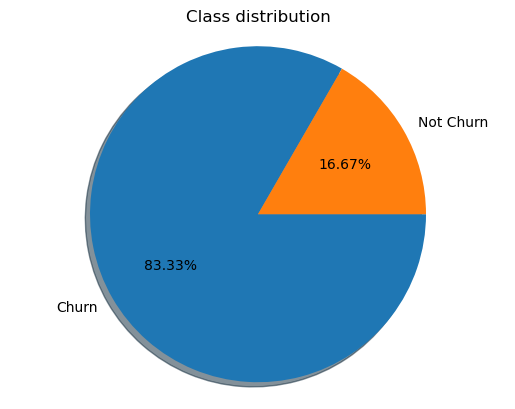

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert customer_df to Pandas DataFrame
customer_df_pandas = customer_df.toPandas()

# Get counts of churn vs non-churn
target_churn = customer_df_pandas["Churn"].value_counts()

# Prepare labels and values for the pie chart
class_names = ['Churn', 'Not Churn']
values = target_churn.tolist()

fig, ax = plt.subplots()
ax.pie(values, labels=class_names, autopct='%1.2f%%',
       shadow=True, startangle=0, counterclock=False)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax.set_title('Class distribution')
plt.show()

Check distribution of continuos variables

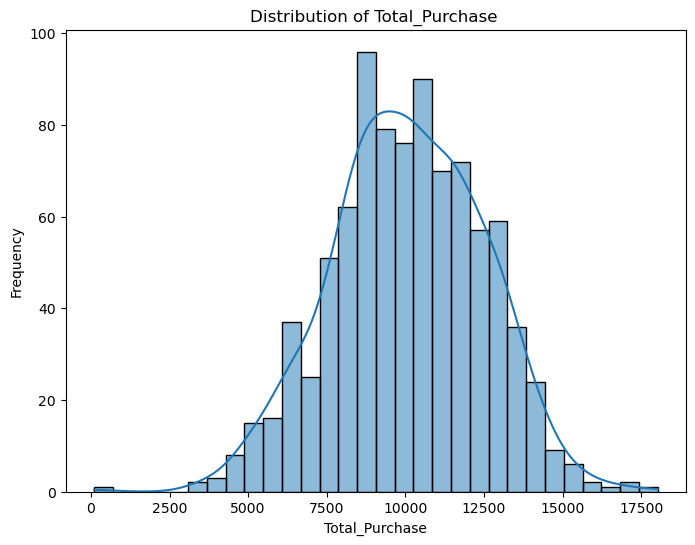

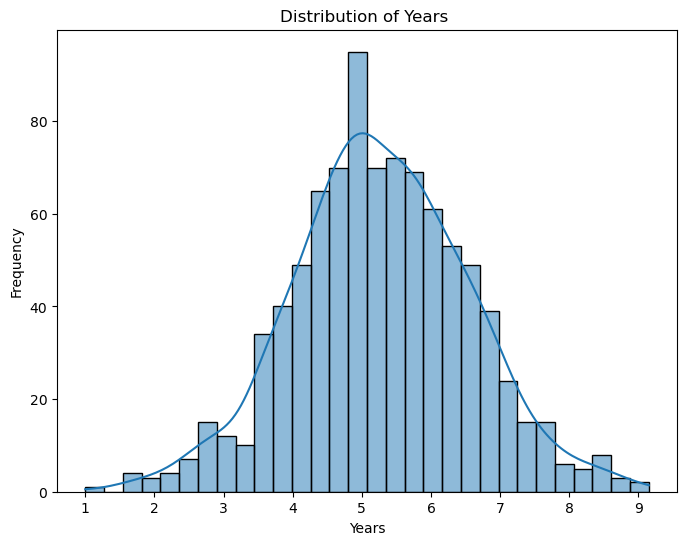

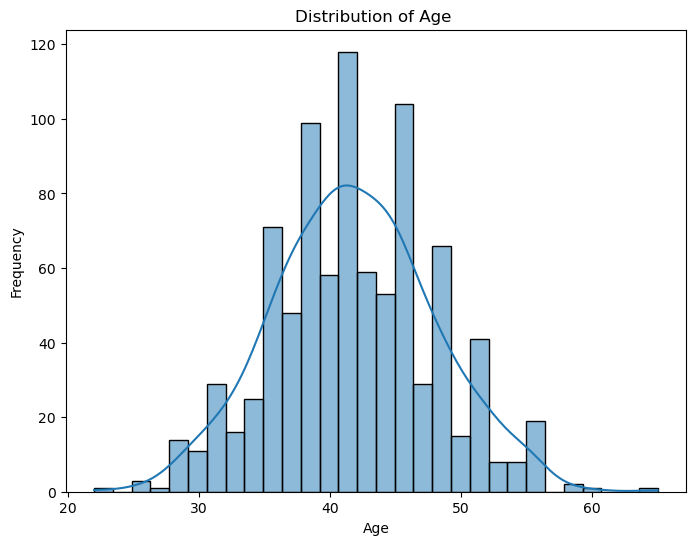

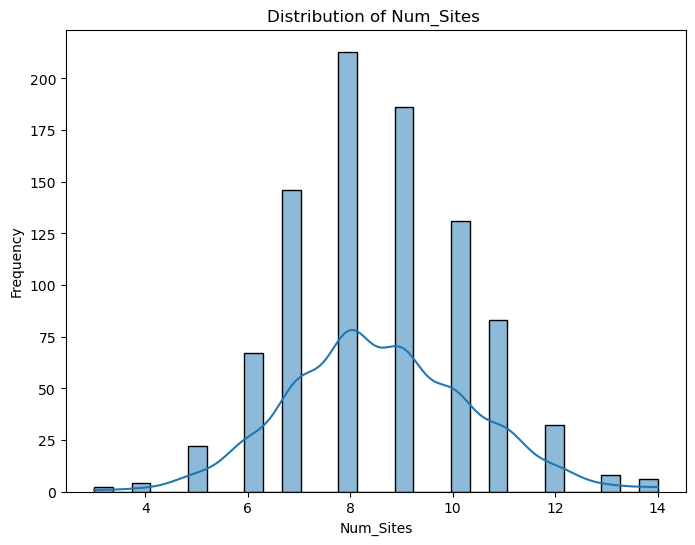

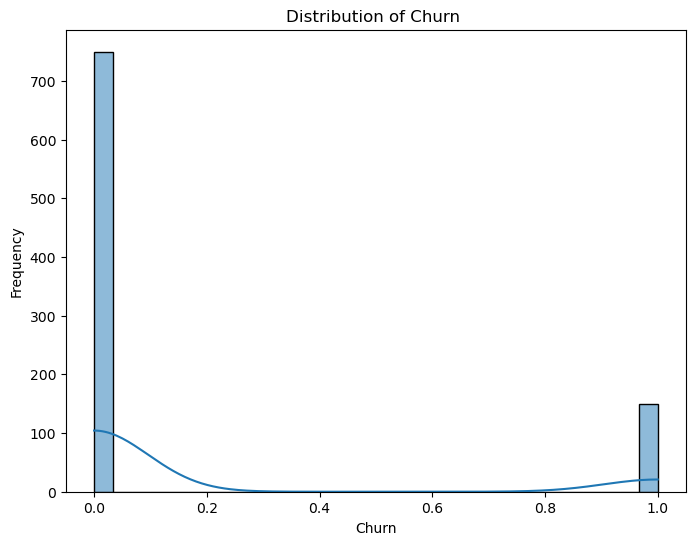

,Total_Purchase,Years,Age,Num_Sites,Churn
count,900.000000,900.000000,900.000000,900.000000,900.000000
mean,10062.824033,5.273156,41.816667,8.587778,0.166667
std,2408.644532,1.274449,6.127560,1.764836,0.372885
min,100.000000,1.000000,22.000000,3.000000,0.000000
25%,8497.122500,4.450000,38.000000,7.000000,0.000000
50%,10045.870000,5.215000,42.000000,8.000000,0.000000
75%,11760.105000,6.110000,46.000000,10.000000,0.000000
max,18026.010000,9.150000,65.000000,14.000000,1.000000


In [18]:
import seaborn as sns
customer_df_pandas= customer_df.toPandas()
numeric_columns= customer_df_pandas[["Total_Purchase","Years","Age","Num_Sites","Churn"]]

for columns in numeric_columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(distribution_columns[columns], kde=True, bins=30)
    plt.title(f"Distribution of {columns} ")
    plt.xlabel(f"{columns}")
    plt.ylabel("Frequency")
    plt.show()

numeric_columns.describe()

In [19]:
from scipy import stats

for column in numeric_columns:
# Perform Shapiro-Wilk test
    stat, p_value = stats.shapiro(numeric_columns[column])
    print(f"Shapiro-Wilk test statistic: {stat}, p-value: {p_value}")


Shapiro-Wilk test statistic: 0.9976645112037659, p-value: 0.23624752461910248
Shapiro-Wilk test statistic: 0.9981220364570618, p-value: 0.4282762408256531
Shapiro-Wilk test statistic: 0.996360182762146, p-value: 0.03495709225535393
Shapiro-Wilk test statistic: 0.9698691964149475, p-value: 1.077860782398854e-12
Shapiro-Wilk test statistic: 0.44935160875320435, p-value: 0.0


Correlation matrix

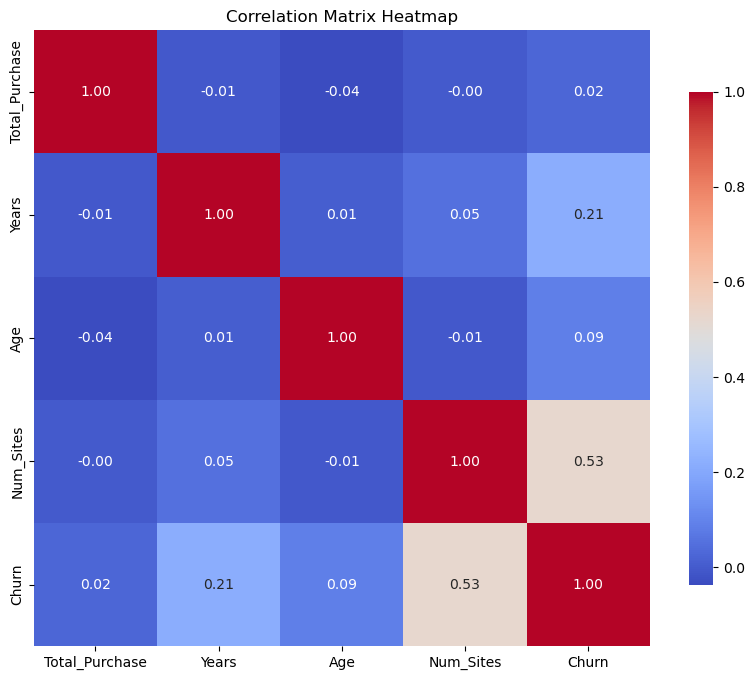

Total_Purchase is poorly correlated with Churn (Correlation: 0.02)
Years is poorly correlated with Churn (Correlation: 0.21)
Age is poorly correlated with Churn (Correlation: 0.09)
Num_Sites is mildly correlated with Churn (Correlation: 0.53)


In [29]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

# Select only the numeric columns.
numeric_columns = ["Total_Purchase","Years","Age","Num_Sites","Churn"]
#Assemble the vector in order to use the MLIB library.
#I assemble the vector: The columns i want to include and how will this columns be named in the vector
assembler_numeric = VectorAssembler(inputCols=numeric_columns, outputCol="features")
#the transform method is combining the inputs from the assembler columns and creating a single vector
vector_customer_data_numeric = assembler_numeric.transform(customer_df)

#Stores the correlation matrix of the features using the correlation.corr method
correlation = Correlation.corr(vector_customer_data_numeric, "features")
#Stores the actual value of correlation matrix into an array
correlation_matrix = correlation.head()[0].toArray()

#Converts those values to a pandas DataFrame for plotting.
correlation_df=pd.DataFrame(correlation_matrix, columns=numeric_columns,index=numeric_columns)

#Creating the heatmap to represent the correlation data.
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_df, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8})

# Title and labels
plt.title("Correlation Matrix Heatmap")
plt.show()

#Explanation of the correlation results.
#Iterate over each colum name
for column in numeric_columns:
    if column != "Churn":  # Skip the 'Churn' column itself
        corr_value = correlation_df.loc[column, "Churn"]  #Extract the correlation value
        if (0.4 <= corr_value < 0.7) or (-0.7 < corr_value <= -0.4):
            print(f"{column} is mildly correlated with Churn (Correlation: {corr_value:.2f})")
        elif (corr_value >= 0.7) or (corr_value <= -0.7):
            print(f"{column} is highly correlated with Churn (Correlation: {corr_value:.2f})")
        elif (0 < corr_value < 0.4) or (-0.4 < corr_value < 0):
            print(f"{column} is poorly correlated with Churn (Correlation: {corr_value:.2f})")


OUR DATA FOLLOWS A NORMAL DISTRIBUTION

# DATA PREPROCESSING

Drop unnecesary columns

In [46]:
columns_to_drop = ["Names", "Location", "Company", "Onboard_date"]
churn_df = customer_df.drop(*columns_to_drop)

Pipeline for preprocessing

In [1]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

# 1. Vector Assembler
assembler = VectorAssembler(inputCols=["Age", "Total_Purchase", "Account_Manager", "Years", "Num_Sites"], 
                            outputCol="features")
# 2. StandardScaler  
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)

# 3. Logistic Regression 
log_reg = LogisticRegression(featuresCol="scaled_features", labelCol="Churn")

# Step 3: Create and Fit the Pipeline
pipeline = Pipeline(stages=[assembler, scaler, log_reg])



AssertionError: 

Train-test split

In [48]:
train_data, test_data = churn_df.randomSplit([0.8, 0.2], seed=42)


Fit the train data with the pipeline (VectorAssembler, StandardScaler and Logistic Regression)

In [49]:
pipeline_model=pipeline.fit(train_data)

Make the predictions with the test data

In [53]:
predictions = pipeline_model.transform(test_data)

In [56]:
predictions.toPandas()

,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Churn,features,scaled_features,rawPrediction,probability,prediction
0,26.0,8787.39,1,5.42,11.0,1,"[26.0, 8787.39, 1.0, 5.42, 11.0]","[-2.5945547031191594, -0.5403379938598103, 1.0...","[0.750887545275658, -0.750887545275658]","[0.6793720600849704, 0.3206279399150296]",0.0
1,28.0,9090.43,1,5.74,10.0,0,"[28.0, 9090.43, 1.0, 5.74, 10.0]","[-2.2656275494996816, -0.41401804808961945, 1....","[1.5890667385099926, -1.5890667385099926]","[0.8304847591974813, 0.16951524080251867]",0.0
2,28.0,11204.23,0,3.67,11.0,0,"[28.0, 11204.23, 0.0, 3.67, 11.0]","[-2.2656275494996816, 0.46710359053573913, -0....","[1.9189502271664212, -1.9189502271664212]","[0.8720213246382786, 0.12797867536172136]",0.0
3,29.0,9617.59,0,5.49,8.0,0,"[29.0, 9617.59, 0.0, 5.49, 8.0]","[-2.101163972689943, -0.19427536523516584, -0....","[4.398297208276825, -4.398297208276825]","[0.9878511463381154, 0.012148853661884562]",0.0
4,30.0,6744.87,0,5.14,9.0,0,"[30.0, 6744.87, 0.0, 5.14, 9.0]","[-1.936700395880204, -1.3917471003623496, -0.9...","[3.5275687381140584, -3.5275687381140584]","[0.9714620864237314, 0.02853791357626856]",0.0
...,...,...,...,...,...,...,...,...,...,...,...
141,55.0,8243.28,0,3.54,6.0,0,"[55.0, 8243.28, 0.0, 3.54, 6.0]","[2.1748890243632677, -0.7671461567855569, -0.9...","[6.251259248614183, -6.251259248614183]","[0.9980756853817431, 0.0019243146182569282]",0.0
142,55.0,8280.03,0,6.33,5.0,0,"[55.0, 8280.03, 0.0, 6.33, 5.0]","[2.1748890243632677, -0.7518271955690359, -0.9...","[5.882469976809453, -5.882469976809453]","[0.9972198599881923, 0.002780140011807708]",0.0
143,55.0,10056.55,0,4.98,8.0,0,"[55.0, 10056.55, 0.0, 4.98, 8.0]","[2.1748890243632677, -0.011298189300362745, -0...","[3.0773679356611945, -3.0773679356611945]","[0.9559494811064108, 0.04405051889358924]",0.0
144,55.0,11158.50,1,4.86,10.0,1,"[55.0, 11158.5, 1.0, 4.86, 10.0]","[2.1748890243632677, 0.4480413838301202, 1.053...","[0.3242990024440062, -0.3242990024440062]","[0.5803715932154961, 0.41962840678450386]",0.0


# EVALUATION

Binary Evaluation and Multiclass evaluator

In [65]:

#Set the Binary Evaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

bi_evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='Churn')

#Set the multiclass evaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
multi_evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='Churn')


In [66]:
print("Binary Classification Evaluator:" , bi_evaluator.evaluate(predictions, {bi_evaluator.metricName: 'areaUnderROC'}))
      
print("Multiclass Classification Evaluator:", multi_evaluator.evaluate(predictions,{multi_evaluator.metricName: "accuracy"}))

Binary Classification Evaluator: 0.7870689655172414
Multiclass Classification Evaluator: 0.8972602739726028
